In [1]:
import pandas as pd
import numpy as np
import nltk
import json
from nltk.stem import WordNetLemmatizer
from collections import Counter
from scipy import sparse
from sklearn.decomposition import PCA
get_ipython().magic(u'matplotlib inline')
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
import datetime
import time
import matplotlib.pyplot as plt

In [2]:
start_time = time.time()
with open('train.json') as data_file:    
    data = json.load(data_file)

In [3]:
## Dictionary

def create_dict_cuisine_ingred(data):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    
    for i in range(len(data)):
        
        # just changing the name of one of the cuisines so
        # it is more readable in the final visualization
        cuisine = data[i]['cuisine']
        if cuisine == 'southern_us':
            cuisine = 'US'

        ingredientsPerCuisine = data[i]['ingredients']
        
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)
            dictCuisineIngred[cuisine] = ingredientsPerCuisine
            
        else: 
            currentList = dictCuisineIngred[cuisine]
            currentList.extend(ingredientsPerCuisine)
            dictCuisineIngred[cuisine] = currentList
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) # unique list of ALL ingredients
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients

def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    termCountMatrix = np.zeros((numCuisines,numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = dictCuisineIngred[cuisine]

        for ingredient in ingredientsPerCuisine:
            j = ingredients.index(ingredient) #in order to know which column to put the term count in, we will ago according to the terms' order in the ingredients array
            termCountMatrix[i,j] += 1

        i += 1

    return termCountMatrix
    

dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)

In [ ]:
 cuisines

In [ ]:
with open('test.json') as data_file:    
    test = json.load(data_file)

In [ ]:
test = test[:1000]

In [ ]:
n = np.zeros((len(test),len(cuisines)))
# nation = np.zeros((len(test),len(cuisines)))
nation = [['']*len(cuisines)]*len(test)
# nation
for i in range(len(test)):
    for j in range(len(cuisines)): 
        for item in test[i]['ingredients']:
            if item in dictCuisineIngred[cuisines[j]]:
                n[i,j] = n[i,j]+1
                
for i in range(len(test)): 
    nation[i] = ['']*len(cuisines)
    for j in range(len(cuisines)):            
        if n[i,j] == len(test[i]['ingredients']):
            nation[i][j] = cuisines[j]

load_time = time.time() - start_time
print(load_time)

In [ ]:
pd.DataFrame(nation).to_csv('prediction.csv', index = False)

In [4]:
test = pd.read_json('test.json')
test['ingredients_reciep'] = [' , '.join(z).strip() for z in test['ingredients']]  
test_clean = test.drop(['id','ingredients'],axis=1)
print(test_clean[0:1])

                                  ingredients_reciep
0  baking powder , eggs , all-purpose flour , rai...


In [5]:
def tf_idf_from_count_matrix(countsMatrix):
    
    countsMatrix = sparse.csr_matrix(countsMatrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(countsMatrix) # normalizes vectors to mean 0 and std 1 and computes tf-idf
    tfidf.toarray() 
    return tfidf.toarray()

In [6]:
tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfIdf_Matrix)
# reduced_data

In [7]:
SSE = [0]*11
for i in [1,2,3,4,5,6,7,8,9,10]:
    kmeans = KMeans(init='k-means++', n_clusters=i, n_init=10)
    kmeans.fit(reduced_data)
    SSE[i] = kmeans.inertia_
    
SSE = SSE[1:11]
SSE


[3.6016936988199002,
 1.5266745184883459,
 0.47458433838049058,
 0.33527871018807121,
 0.24334143577900236,
 0.17180082211901798,
 0.12238941296072968,
 0.097821654183876089,
 0.067534891465589136,
 0.048545855976632607]

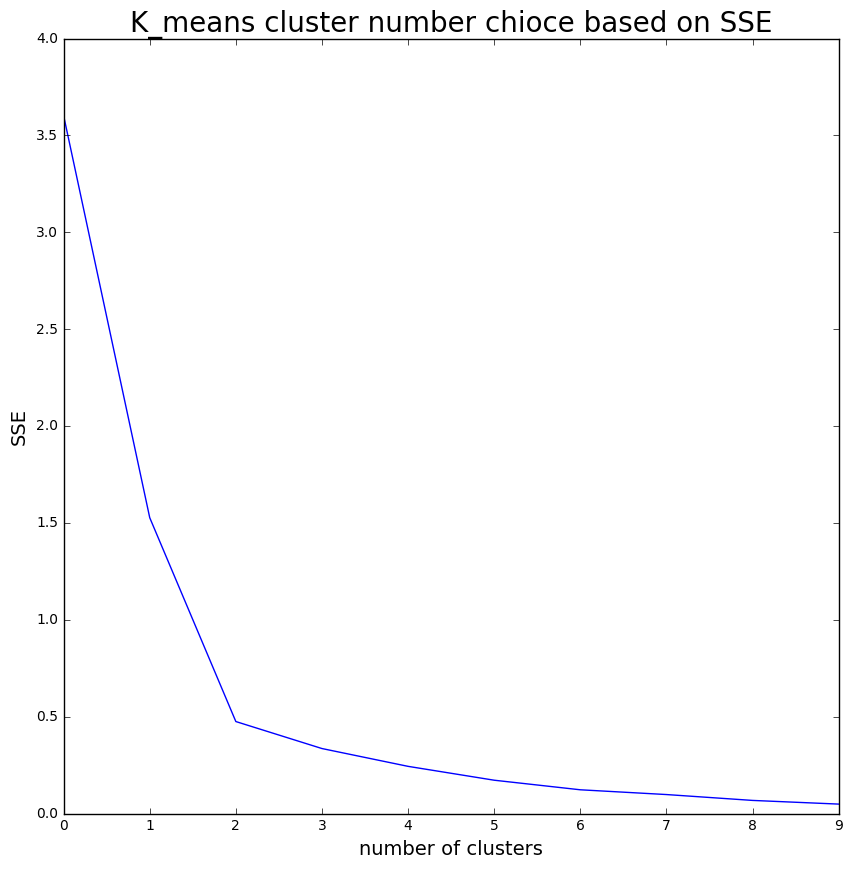

In [8]:
plt.figure(figsize=(10,10))
plt.plot(list(range(10)),SSE)

plt.ylabel('SSE',fontsize=14)
plt.xlabel('number of clusters',fontsize=14)
plt.title('K_means cluster number chioce based on SSE',fontsize=20)
plt.savefig('kmeans.jpg')
plt.show()

In [ ]:
def kmeans_cultures(numOfClusters):
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)


labels = kmeans_cultures(4)

# cuisines = pd.DataFrame(cuisines,columns=['cuisines'])
# labels = pd.DataFrame(labels,columns=['labels'])
# objs = [cuisines,labels]
# k_means_food = pd.concat(objs, axis=1, join='outer')

labels

In [ ]:
cuisines

In [ ]:
i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: # if it is A itself - we obviously wouldn't want this (will be exactly 1)
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
       
    i += 1

In [ ]:
# for i in range(20):
#     print(ax.text(rdata[i,0],rdata[i,1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w'))
# rdata[20,0]
cuisines[0]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
rdata = reduced_data
i=0
figureRatios = (15,20)
x = []
y = []
color = []
area = []


colorPalette = ['#B4F060','#93BEFF', '#F9B78B','#F78EFF', '#D0B8AC'] 
plt.figure(1, figsize=figureRatios)
for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*2000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine:
    
    i += 1


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 
# for i in range(10):
ax.text(rdata[0,0],rdata[0,1], cuisines[0], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[1,0],rdata[1,1], cuisines[1], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[2,0],rdata[2,1], cuisines[2], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[3,0],rdata[3,1], cuisines[3], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[4,0],rdata[4,1], cuisines[4], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[5,0],rdata[5,1], cuisines[5], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[6,0],rdata[6,1], cuisines[6], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[7,0],rdata[7,1], cuisines[7], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[8,0],rdata[8,1], cuisines[8], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[9,0],rdata[9,1], cuisines[9], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[10,0],rdata[10,1], cuisines[10], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[11,0],rdata[11,1], cuisines[11], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[12,0],rdata[12,1], cuisines[12], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[13,0],rdata[13,1], cuisines[13], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[14,0],rdata[14,1], cuisines[14], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[15,0],rdata[15,1], cuisines[15], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[16,0],rdata[16,1], cuisines[16], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[17,0],rdata[17,1], cuisines[17], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[18,0],rdata[18,1], cuisines[18], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
ax.text(rdata[19,0],rdata[19,1], cuisines[19], size=10.6,horizontalalignment='center', fontweight = 'bold', color='black')
plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PCA_first')
plt.ylabel('PCA_second')
plt.title('Cluster by cuisines',fontsize=20)
# plt.axis('off') # removing the PC axes
plt.savefig('Countries.jpg')
plt.show()
